In [1]:
import pandas as pd

In [66]:
# 检查数据
def check_data(data):
    print("data head lines：")
    display(data.head())
    print("\n data info：")
    data.info()
    print("\n check missing values：")
    print(data.isnull().sum())

file_path = 'merged_data.xlsx'
data = pd.read_excel(file_path)
check_data(data)

data head lines：


,Date,DPRIME,Close,Volume,Open,High,Low
0,06/21/2024,8.5,905.260,7465581,900.10,917.9499,863.22
1,06/20/2024,8.5,917.635,13432940,961.29,1014.0200,900.32
2,06/18/2024,8.5,920.010,8762073,897.00,938.8800,883.31
3,06/17/2024,8.5,887.410,8911764,857.40,921.9100,828.09
4,06/14/2024,8.5,844.540,6598781,846.93,872.0000,825.61



 data info：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2516 non-null   object 
 1   DPRIME  2516 non-null   float64
 2   Close   2516 non-null   float64
 3   Volume  2516 non-null   int64  
 4   Open    2516 non-null   float64
 5   High    2516 non-null   float64
 6   Low     2516 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 137.7+ KB

 check missing values：
Date      0
DPRIME    0
Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64


In [3]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt

In [4]:
# 目前用的是tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [67]:
#adjust：timesteps
time_steps7 = 7
time_steps30 = 30
time_steps60 = 60
time_steps90 = 90

In [104]:
time_steps = time_steps90

In [8]:
from sklearn.preprocessing import StandardScaler

In [69]:
# pre-processing
def preprocess_data(train_set, valid_set):
    scaler = MinMaxScaler(feature_range=(0, 1))
    # scaler = StandardScaler()

    # normalization
    train_data = scaler.fit_transform(train_set['Close'].values.reshape(-1, 1))
    valid_data = scaler.transform(valid_set['Close'].values.reshape(-1, 1))

    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])

    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[i-time_steps:i, 0])
        y_valid.append(valid_data[i, 0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

    x_valid, y_valid = np.array(x_valid), np.array(y_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))

    return x_train, y_train, x_valid, y_valid, scaler

In [70]:
# train parameter：LSTM
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [71]:
# train model
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

In [72]:
# predict
def make_prediction(model, x_valid, scaler):
    predictions = model.predict(x_valid)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [80]:
# predict future
def predict_future(model, recent_data, scaler, future_days, time_steps):
    recent_data_scaled = scaler.transform(recent_data.reshape(-1, 1))

    # Create a list to hold the predicted values
    future_predictions = []

    # Loop to predict each future day
    for _ in range(future_days):
        # Prepare the input data for the model
        x_input = np.array(recent_data_scaled[-time_steps:]).reshape(1, time_steps, 1)

        # Predict the next value
        pred_scaled = model.predict(x_input)

        # Inverse transform the prediction to get the actual value
        pred = scaler.inverse_transform(pred_scaled)

        # Append the prediction to the list
        future_predictions.append(pred[0, 0])

        # Append the prediction to the recent_data_scaled to use it for the next prediction
        recent_data_scaled = np.append(recent_data_scaled, pred_scaled)

    return future_predictions

In [74]:
data['Date'] = pd.to_datetime(data['Date'])
train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()
valid_set = data[(data['Date'] >= '2023-06-24') & (data['Date'] < '2024-06-24')].copy()
# from past to future
train_set = train_set.sort_values(by='Date')
valid_set = valid_set.sort_values(by='Date')

In [75]:
train_set

,Date,DPRIME,Close,Volume,Open,High,Low
2515,2014-06-24,3.25,25.34,243530,25.52,25.9800,25.303
2514,2014-06-25,3.25,25.27,491864,25.24,25.4900,24.570
2513,2014-06-26,3.25,25.45,342669,26.00,26.0000,25.210
2512,2014-06-27,3.25,24.69,1482237,25.24,25.4050,24.690
2511,2014-06-30,3.25,25.27,648122,24.69,25.3900,24.610
...,...,...,...,...,...,...,...
254,2023-06-16,8.25,230.77,3034647,245.00,245.7800,230.370
253,2023-06-20,8.25,222.40,3366546,227.30,235.7096,219.330
252,2023-06-21,8.25,219.91,2603561,221.00,227.0000,217.200
251,2023-06-22,8.25,226.46,3938637,221.99,241.9699,221.140


In [76]:
valid_set

,Date,DPRIME,Close,Volume,Open,High,Low
249,2023-06-26,8.25,216.500,2840615,219.71,229.9900,213.080
248,2023-06-27,8.25,226.170,2432466,222.41,228.3400,218.510
247,2023-06-28,8.25,235.940,2666737,223.27,238.1599,220.285
246,2023-06-29,8.25,235.930,2726553,240.80,248.8200,231.350
245,2023-06-30,8.25,249.250,2552965,240.00,253.9600,239.880
...,...,...,...,...,...,...,...
4,2024-06-14,8.50,844.540,6598781,846.93,872.0000,825.610
3,2024-06-17,8.50,887.410,8911764,857.40,921.9100,828.090
2,2024-06-18,8.50,920.010,8762073,897.00,938.8800,883.310
1,2024-06-20,8.50,917.635,13432940,961.29,1014.0200,900.320


# time_steps = 7, RMSE = 206.33732084340699


In [77]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25
71/71 [==============================] - 6s 15ms/step - loss: 0.0029
Epoch 2/25
71/71 [==============================] - 1s 10ms/step - loss: 4.7570e-04
Epoch 3/25
71/71 [==============================] - 1s 10ms/step - loss: 5.7007e-04
Epoch 4/25
71/71 [==============================] - 1s 10ms/step - loss: 6.4714e-04
Epoch 5/25
71/71 [==============================] - 1s 9ms/step - loss: 5.0179e-04
Epoch 6/25
71/71 [==============================] - 1s 10ms/step - loss: 5.2613e-04
Epoch 7/25
71/71 [==============================] - 1s 10ms/step - loss: 4.2371e-04
Epoch 8/25
71/71 [==============================] - 1s 10ms/step - loss: 4.2289e-04
Epoch 9/25
71/71 [==============================] - 1s 10ms/step - loss: 3.9390e-04
Epoch 10/25
71/71 [==============================] - 1s 10ms/step - loss: 5.1099e-04
Epoch 11/25
71/71 [==============================] - 1s 10ms/step - loss: 3.5953e-04
Epoch 12/25
71/71 [==============================] - 1s 10ms/step - loss: 4.688

In [78]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 7, 50)             10400     
                                                                 
 dropout_6 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_7 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_7 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [88]:
# To make the results more visible, projections were made for the next 90 days
recent_data = valid_set['Close'].values[-time_steps:]
future_preds = predict_future(model, recent_data, scaler, future_days=90, time_steps=7)
print(future_preds)

1/1 [==============================] - 0s 25ms/step
[585.05524, 559.82654, 535.96515, 513.0183, 490.94794, 469.7814, 449.7494, 430.78998, 418.57858, 407.12537, 396.5139, 386.7691, 377.86887, 369.77017, 362.41458, 355.74356, 349.51938, 343.72116, 338.3168, 333.2698, 328.54462, 324.10715, 319.92706, 315.97678, 312.2383, 308.6941, 305.32797, 302.12518, 299.0727, 296.15894, 293.3737, 290.70786, 288.15308, 285.70178, 283.34714, 281.08292, 278.90338, 276.80338, 274.7781, 272.8233, 270.93488, 269.109, 267.3425, 265.632, 263.9747, 262.36777, 260.8087, 259.2951, 257.82492, 256.39597, 255.00629, 253.65425, 252.33804, 251.05608, 249.80692, 248.58913, 247.40149, 246.24265, 245.11143, 244.00677, 242.92769, 241.8731, 240.84215, 239.83391, 238.84749, 237.88214, 236.93715, 236.01172, 235.10529, 234.21704, 233.34637, 232.4929, 231.65584, 230.83472, 230.029, 229.23824, 228.46198, 227.69969, 226.95102, 226.21544, 225.49277, 224.78244, 224.0841, 223.39752, 222.72227, 222.05801, 221.40448, 220.76144, 220.1

In [89]:
last_date = valid_set['Date'].values[-1]
future_dates = pd.date_range(last_date, periods=91)[1:]
future_df = pd.DataFrame({'Date': future_dates, 'Close': future_preds})
future_df

,Date,Close
0,2024-06-22,585.055237
1,2024-06-23,559.826538
2,2024-06-24,535.965149
3,2024-06-25,513.018311
4,2024-06-26,490.947937
...,...,...
85,2024-09-15,222.058014
86,2024-09-16,221.404480
87,2024-09-17,220.761444
88,2024-09-18,220.128479


LSTM RMSE on validation set: 206.33732084340699


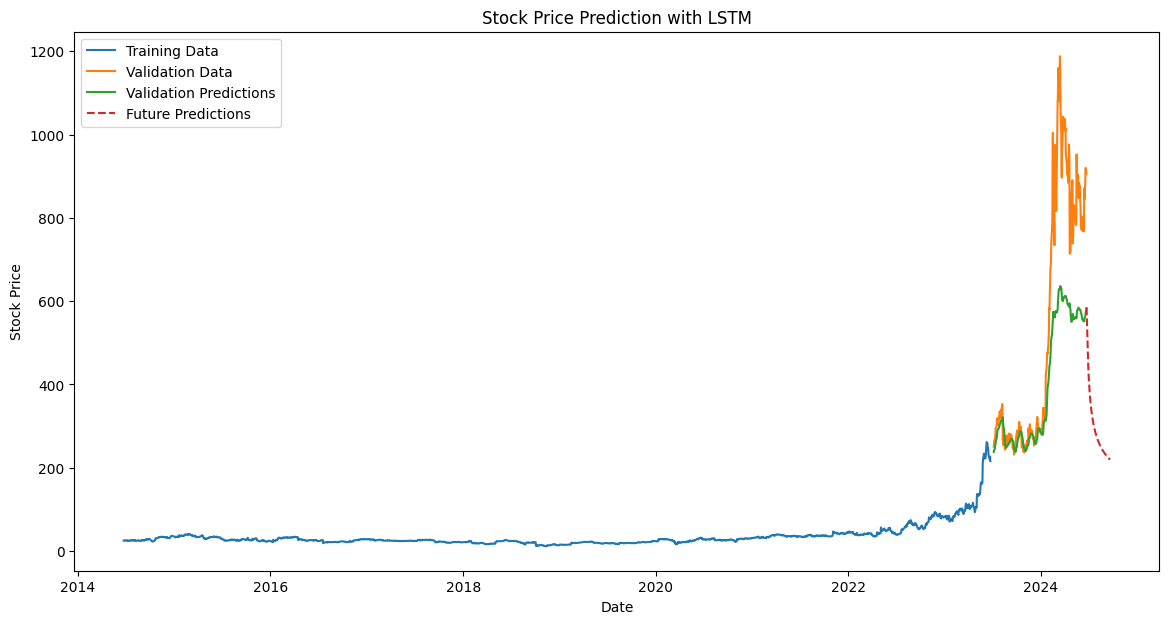

In [90]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], valid_preds, label='Validation Predictions')
plt.plot(future_df['Date'], future_df['Close'], label='Future Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# time_steps = 30, RMSE = 197.00375051098735

In [92]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25
70/70 [==============================] - 7s 29ms/step - loss: 0.0022
Epoch 2/25
70/70 [==============================] - 2s 29ms/step - loss: 8.4892e-04
Epoch 3/25
70/70 [==============================] - 2s 29ms/step - loss: 6.2697e-04
Epoch 4/25
70/70 [==============================] - 2s 29ms/step - loss: 6.5649e-04
Epoch 5/25
70/70 [==============================] - 2s 31ms/step - loss: 5.5286e-04
Epoch 6/25
70/70 [==============================] - 3s 46ms/step - loss: 4.9757e-04
Epoch 7/25
70/70 [==============================] - 2s 30ms/step - loss: 4.5641e-04
Epoch 8/25
70/70 [==============================] - 2s 29ms/step - loss: 4.3851e-04
Epoch 9/25
70/70 [==============================] - 2s 29ms/step - loss: 4.8455e-04
Epoch 10/25
70/70 [==============================] - 2s 29ms/step - loss: 4.2750e-04
Epoch 11/25
70/70 [==============================] - 2s 30ms/step - loss: 4.8182e-04
Epoch 12/25
70/70 [==============================] - 3s 46ms/step - loss: 3.71

In [93]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# To make the results more visible, projections were made for the next 90 days
recent_data = valid_set['Close'].values[-time_steps:]
future_preds = predict_future(model, recent_data, scaler, future_days=90, time_steps=time_steps)
print(future_preds)

1/1 [==============================] - 0s 24ms/step
[686.74023, 625.50165, 548.65643, 466.96423, 388.06976, 316.7454, 254.6206, 202.5687, 160.59425, 127.87192, 103.21195, 85.44598, 73.62557, 66.61652, 63.51167, 63.61785, 66.416595, 71.46055, 78.348465, 86.6889, 96.27599, 106.748085, 117.74097, 128.95386, 140.03162, 150.66174, 160.64774, 169.75513, 177.86734, 184.94247, 190.94017, 195.93832, 199.80307, 202.58536, 204.32938, 205.0899, 204.94354, 203.99161, 202.35564, 200.17052, 197.57732, 194.7162, 191.72002, 188.71002, 185.79193, 183.05418, 180.56679, 178.38153, 176.53284, 175.03952, 173.9065, 173.1268, 172.68402, 172.5541, 172.70697, 173.10872, 173.72264, 174.51074, 175.43484, 176.45772, 177.5439, 178.66028, 179.777, 180.86758, 181.90952, 182.88405, 183.77664, 184.5766, 185.27704, 185.87468, 186.36964, 186.76486, 187.06569, 187.27983, 187.41643, 187.48569, 187.4989, 187.46739, 187.40256, 187.31532, 187.21606, 187.11417, 187.01784, 186.93427, 186.86926, 186.82733, 186.81174, 186.82446, 

In [95]:
last_date = valid_set['Date'].values[-1]
future_dates = pd.date_range(last_date, periods=91)[1:]
future_df = pd.DataFrame({'Date': future_dates, 'Close': future_preds})
future_df

,Date,Close
0,2024-06-22,686.740234
1,2024-06-23,625.501648
2,2024-06-24,548.656433
3,2024-06-25,466.964233
4,2024-06-26,388.069763
...,...,...
85,2024-09-15,186.827332
86,2024-09-16,186.811737
87,2024-09-17,186.824463
88,2024-09-18,186.866501


LSTM RMSE on validation set: 197.00375051098735


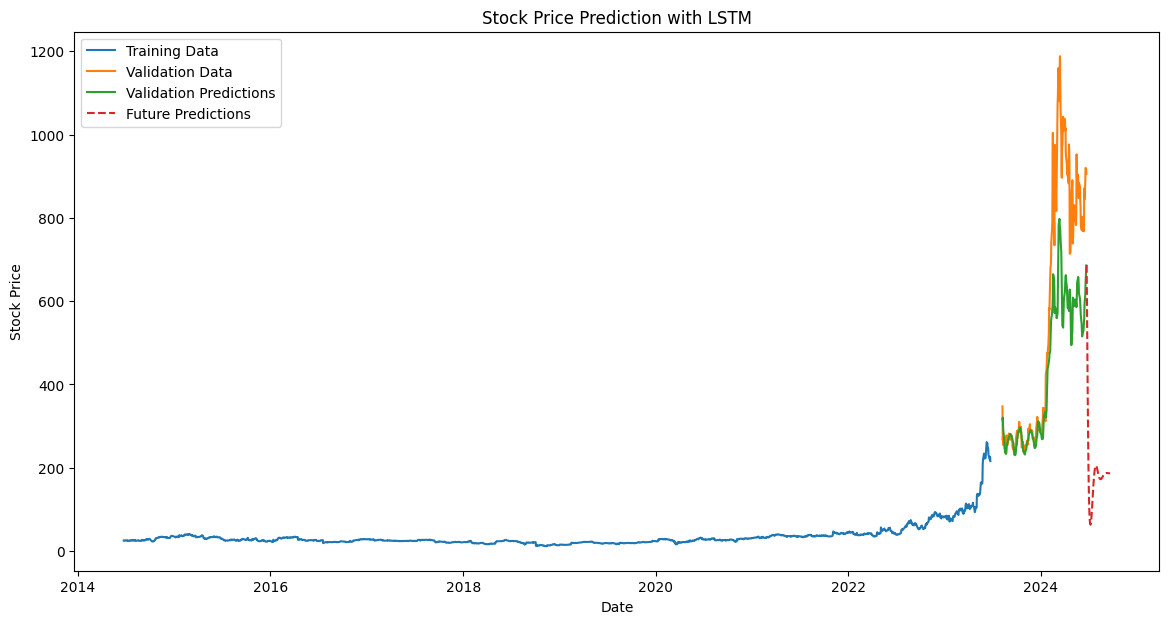

In [96]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], valid_preds, label='Validation Predictions')
plt.plot(future_df['Date'], future_df['Close'], label='Future Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# time_steps = 60, RMSE = 192.99116578387125

In [99]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25
69/69 [==============================] - 8s 69ms/step - loss: 0.0019
Epoch 2/25
69/69 [==============================] - 8s 110ms/step - loss: 8.9749e-04
Epoch 3/25
69/69 [==============================] - 4s 61ms/step - loss: 7.5906e-04
Epoch 4/25
69/69 [==============================] - 8s 119ms/step - loss: 4.5743e-04
Epoch 5/25
69/69 [==============================] - 4s 64ms/step - loss: 4.7400e-04
Epoch 6/25
69/69 [==============================] - 3s 49ms/step - loss: 4.1954e-04
Epoch 7/25
69/69 [==============================] - 4s 62ms/step - loss: 3.9378e-04
Epoch 8/25
69/69 [==============================] - 4s 56ms/step - loss: 4.7400e-04
Epoch 9/25
69/69 [==============================] - 3s 50ms/step - loss: 3.8243e-04
Epoch 10/25
69/69 [==============================] - 3s 48ms/step - loss: 4.6896e-04
Epoch 11/25
69/69 [==============================] - 5s 71ms/step - loss: 5.2069e-04
Epoch 12/25
69/69 [==============================] - 3s 50ms/step - loss: 3.

In [100]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 60, 50)            10400     
                                                                 
 dropout_12 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 50)                20200     
                                                                 
 dropout_13 (Dropout)        (None, 50)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [101]:
# To make the results more visible, projections were made for the next 90 days
recent_data = valid_set['Close'].values[-time_steps:]
future_preds = predict_future(model, recent_data, scaler, future_days=90, time_steps=time_steps)
print(future_preds)

1/1 [==============================] - 0s 25ms/step
[658.64276, 599.8993, 536.115, 472.82764, 413.75784, 360.417, 313.2054, 271.9683, 236.32385, 205.77249, 179.71313, 157.47844, 138.43872, 122.15139, 108.448235, 97.37172, 89.00739, 83.34052, 80.220314, 79.381424, 80.49598, 83.228294, 87.262825, 92.318, 98.15349, 104.56883, 111.400154, 118.50843, 125.77797, 133.1131, 140.43352, 147.67244, 154.7727, 161.68686, 168.3731, 174.7963, 180.93262, 186.75903, 192.25816, 197.41827, 202.23227, 206.69731, 210.81476, 214.59093, 218.03554, 221.16222, 223.98756, 226.53088, 228.81378, 230.85925, 232.69154, 234.3353, 235.81483, 237.15408, 238.37575, 239.50095, 240.54927, 241.53789, 242.48203, 243.39467, 244.28645, 245.16641, 246.04004, 246.91107, 247.78156, 248.65146, 249.51941, 250.38254, 251.23721, 252.07887, 252.90253, 253.70296, 254.47493, 255.21355, 255.91417, 256.57285, 257.18628, 257.75192, 258.26816, 258.73425, 259.15036, 259.5174, 259.83716, 260.1122, 260.34558, 260.54092, 260.70227, 260.83386,

In [102]:
last_date = valid_set['Date'].values[-1]
future_dates = pd.date_range(last_date, periods=91)[1:]
future_df = pd.DataFrame({'Date': future_dates, 'Close': future_preds})
future_df

,Date,Close
0,2024-06-22,658.642761
1,2024-06-23,599.899292
2,2024-06-24,536.114990
3,2024-06-25,472.827637
4,2024-06-26,413.757843
...,...,...
85,2024-09-15,260.540924
86,2024-09-16,260.702271
87,2024-09-17,260.833862
88,2024-09-18,260.940063


LSTM RMSE on validation set: 192.99116578387125


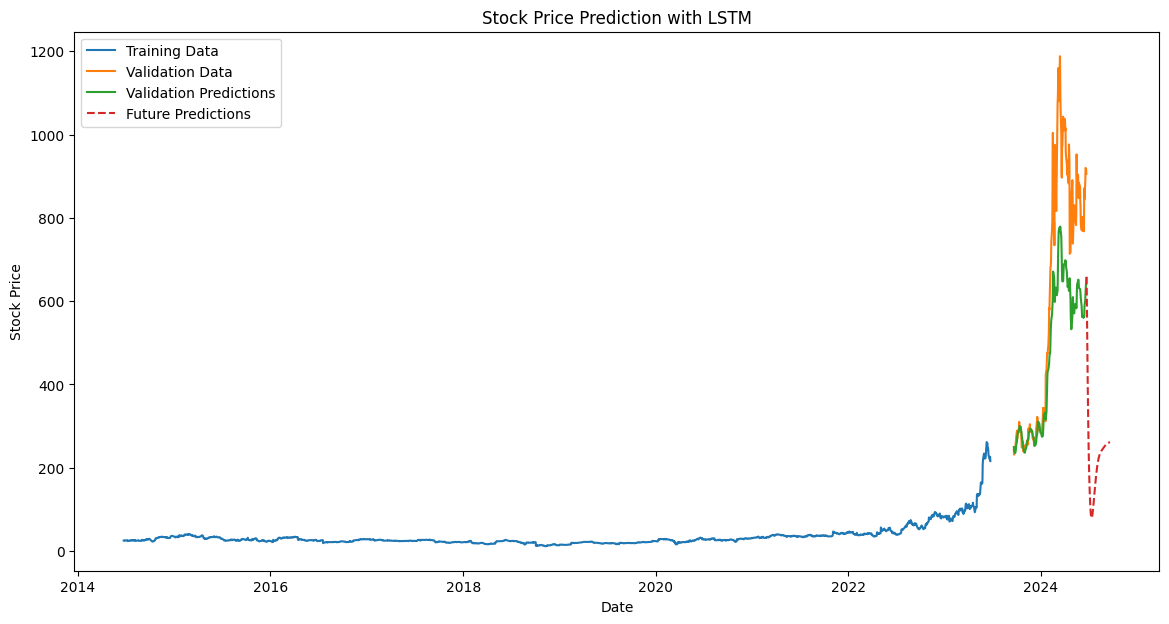

In [103]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], valid_preds, label='Validation Predictions')
plt.plot(future_df['Date'], future_df['Close'], label='Future Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# time_steps = 90, RMSE = 157.09002646232395

In [105]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25
68/68 [==============================] - 10s 62ms/step - loss: 0.0020
Epoch 2/25
68/68 [==============================] - 4s 62ms/step - loss: 5.7688e-04
Epoch 3/25
68/68 [==============================] - 5s 81ms/step - loss: 7.1444e-04
Epoch 4/25
68/68 [==============================] - 4s 62ms/step - loss: 6.0035e-04
Epoch 5/25
68/68 [==============================] - 5s 66ms/step - loss: 5.9538e-04
Epoch 6/25
68/68 [==============================] - 5s 79ms/step - loss: 7.9717e-04
Epoch 7/25
68/68 [==============================] - 4s 63ms/step - loss: 5.1037e-04
Epoch 8/25
68/68 [==============================] - 5s 68ms/step - loss: 4.4164e-04
Epoch 9/25
68/68 [==============================] - 5s 77ms/step - loss: 4.2194e-04
Epoch 10/25
68/68 [==============================] - 4s 62ms/step - loss: 5.9047e-04
Epoch 11/25
68/68 [==============================] - 5s 72ms/step - loss: 5.3712e-04
Epoch 12/25
68/68 [==============================] - 5s 74ms/step - loss: 5.0

In [107]:
recent_data = valid_set['Close'].values[-time_steps:]
future_preds = predict_future(model, recent_data, scaler, future_days=90, time_steps = time_steps)
print(future_preds)

1/1 [==============================] - 0s 51ms/step
[728.55176, 698.6722, 662.3018, 624.3808, 587.33014, 552.38855, 520.2035, 491.10883, 465.2528, 442.65762, 423.25262, 406.89566, 393.39273, 382.5148, 374.0125, 367.62564, 363.09238, 360.1548, 358.56375, 358.08334, 358.49396, 359.59457, 361.2047, 363.16415, 365.33438, 367.5972, 369.85464, 372.02747, 374.05463, 375.89087, 377.5053, 378.88043, 380.0091, 380.8935, 381.54333, 381.9738, 382.20447, 382.25745, 382.1569, 381.92703, 381.59204, 381.17532, 380.6984, 380.18106, 379.64105, 379.09384, 378.55228, 378.02747, 377.52783, 377.06015, 376.62878, 376.23688, 375.88608, 375.5765, 375.3076, 375.0774, 374.8839, 374.7243, 374.59546, 374.49405, 374.41675, 374.3603, 374.32144, 374.29703, 374.28442, 374.28088, 374.28406, 374.2922, 374.3034, 374.31613, 374.3293, 374.34192, 374.35336, 374.3629, 374.37042, 374.3756, 374.37833, 374.37878, 374.37698, 374.37317, 374.36752, 374.36032, 374.35178, 374.3423, 374.332, 374.3212, 374.31015, 374.2991, 374.28812, 

In [108]:
last_date = valid_set['Date'].values[-1]
future_dates = pd.date_range(last_date, periods=91)[1:]
future_df = pd.DataFrame({'Date': future_dates, 'Close': future_preds})
future_df

,Date,Close
0,2024-06-22,728.551758
1,2024-06-23,698.672180
2,2024-06-24,662.301819
3,2024-06-25,624.380798
4,2024-06-26,587.330139
...,...,...
85,2024-09-15,374.321198
86,2024-09-16,374.310150
87,2024-09-17,374.299103
88,2024-09-18,374.288116


LSTM RMSE on validation set: 157.09002646232395


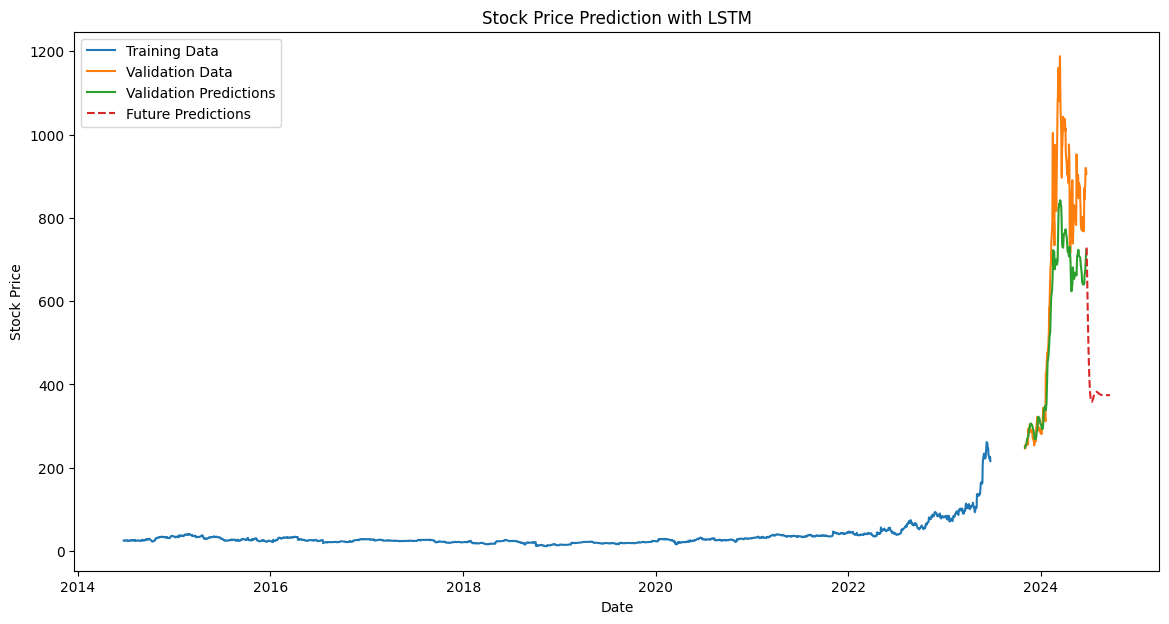

In [109]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(valid_set['Date'][time_steps:], valid_set['Close'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['Date'][time_steps:], valid_preds, label='Validation Predictions')
plt.plot(future_df['Date'], future_df['Close'], label='Future Predictions', linestyle='dashed')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()

# StandardScaler - bad performance

In [ ]:
# call pre-processing
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, valid_set)
# train model
model = build_model()
train_model(model, x_train, y_train)
# make prediction
valid_preds = make_prediction(model, x_valid, scaler)

D:\Users\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - loss: 0.4173
Epoch 2/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0282
Epoch 3/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0245
Epoch 4/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 0.0253
Epoch 5/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 0.0224
Epoch 6/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 0.0253
Epoch 7/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 0.0257
Epoch 8/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0214
Epoch 9/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0224
Epoch 10/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0219
Epoch 11/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0186
Epoch 12/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0231
Epoch 13/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0175
Epoch 14/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0193
Epoch 15/25
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - loss: 0.0203
Epoc

LSTM RMSE on validation set: 465.15327136256775


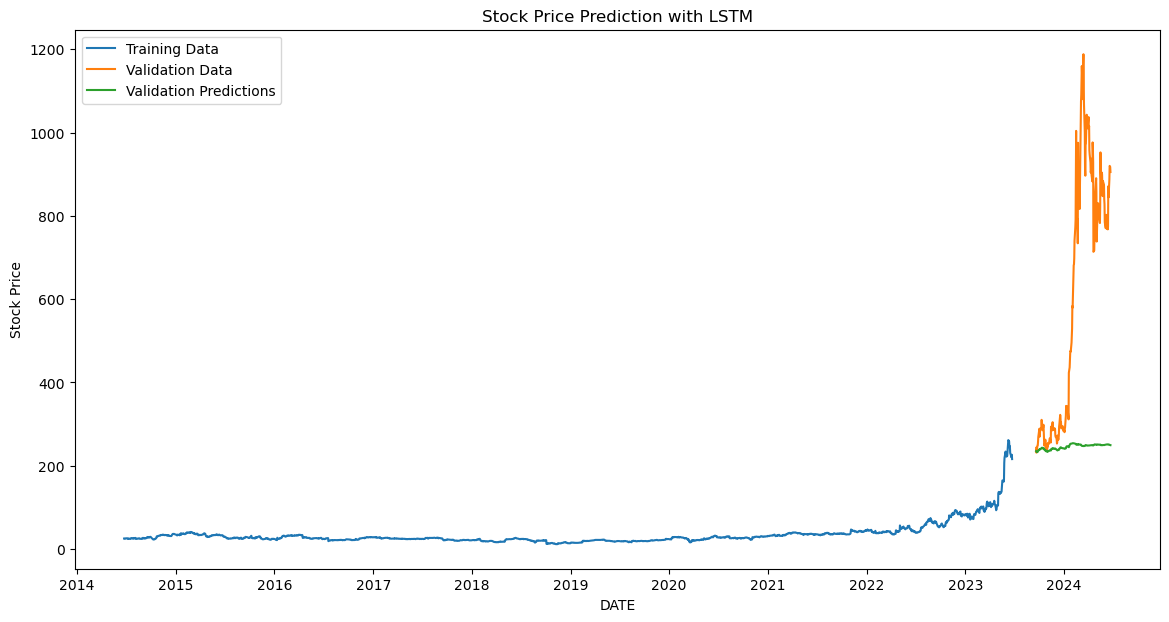

In [ ]:
# validate by RMSE
valid_rmse = np.sqrt(mean_squared_error(valid_set['Close/Last'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# visualize
plt.figure(figsize=(14, 7))
plt.plot(train_set['DATE'], train_set['Close/Last'], label='Training Data')
plt.plot(valid_set['DATE'][time_steps:], valid_set['Close/Last'].values[time_steps:], label='Validation Data')
plt.plot(valid_set['DATE'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('DATE')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()